### LASSO parameter range experiments, summary across all genes

In [1]:
import os
import itertools as it

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from scipy.stats import pearsonr, spearmanr
import seaborn as sns

import pancancer_evaluation.config as cfg
import pancancer_evaluation.utilities.data_utilities as du
import pancancer_evaluation.utilities.analysis_utilities as au

%load_ext autoreload
%autoreload 2

In [2]:
base_results_dir = os.path.join(
    cfg.repo_root, '02_cancer_type_classification', 'results', 'lasso_range_lr_all_features'
)

training_dataset = 'all_other_cancers'
results_dir = os.path.join(base_results_dir, training_dataset)

# cutoff to filter out "dummy regressor" over-regularized models
# these can deflate performance around feature count 0, which can lead to
# spurious positive correlations between model size and performance
# set to None for no cutoff
quantile_cutoff = 0.01

# 'aupr' or 'auroc'
metric = 'aupr'

# 'pearson', 'spearman', or 'ccc'
correlation = 'pearson'

output_plots = True
output_plots_dir = cfg.cancer_type_lasso_range_dir

### Get coefficient information for each lasso penalty

In [3]:
nz_coefs_df = []

# get pancancer coefs info for now
for coef_info in au.generate_nonzero_coefficients_lasso_range(results_dir):
    (gene,
     cancer_type,
     seed,
     lasso_param,
     coefs_list) = coef_info
    for fold_no, coefs in enumerate(coefs_list):
        nz_coefs_df.append(
            [gene, cancer_type, lasso_param, seed, fold_no, len(coefs)]
        )
        
nz_coefs_df = pd.DataFrame(
    nz_coefs_df,
    columns=['gene', 'cancer_type', 'lasso_param', 'seed', 'fold', 'nz_coefs']
)
nz_coefs_df.lasso_param = nz_coefs_df.lasso_param.astype(float)
print(nz_coefs_df.shape)
print(nz_coefs_df.gene.unique())
nz_coefs_df.head()

(35520, 6)
['MAP3K1' 'TP53' 'RB1' 'BRAF' 'ARID2' 'JAK3' 'H3F3A' 'MET' 'CDKN2A'
 'NCOR1' 'FLT3' 'CREBBP' 'SMARCA4' 'FOXL2' 'BCOR' 'NRAS' 'ERBB2' 'ARID1A'
 'PDGFRA' 'MED12' 'SETBP1' 'KDM6A' 'STK11' 'NOTCH1' 'SMAD4' 'ARID1B'
 'FGFR2' 'FBXW7' 'EGFR' 'APC' 'EP300' 'ATRX' 'HRAS' 'GNAS' 'CTNNB1' 'PTEN'
 'DNMT1' 'PIK3CA' 'NOTCH2' 'GATA2' 'CARD11' 'KIT' 'ATM' 'CDH1' 'BAP1'
 'SF3B1' 'RNF43' 'NF1' 'PRDM1' 'NFE2L2' 'BRCA2' 'SETD2' 'CASP8' 'SPOP'
 'PPP2R1A' 'KRAS']


,gene,cancer_type,lasso_param,seed,fold,nz_coefs
0,MAP3K1,BRCA,1.0,1,0,113
1,MAP3K1,BRCA,1.0,1,1,113
2,MAP3K1,BRCA,1.0,1,2,132
3,MAP3K1,BRCA,1.0,1,3,128
4,MAP3K1,UCEC,2000.0,42,0,8788


### Get performance information for each lasso penalty

In [4]:
perf_df = au.load_prediction_results_lasso_range(results_dir, training_dataset)
perf_df.lasso_param = perf_df.lasso_param.astype(float)

print(perf_df.shape)
print(perf_df.gene.unique())
perf_df.head()

(106560, 10)
['MAP3K1' 'TP53' 'RB1' 'BRAF' 'ARID2' 'JAK3' 'H3F3A' 'MET' 'CDKN2A'
 'NCOR1' 'FLT3' 'CREBBP' 'SMARCA4' 'FOXL2' 'BCOR' 'NRAS' 'ERBB2' 'ARID1A'
 'PDGFRA' 'MED12' 'SETBP1' 'KDM6A' 'STK11' 'NOTCH1' 'SMAD4' 'ARID1B'
 'FGFR2' 'FBXW7' 'EGFR' 'APC' 'EP300' 'ATRX' 'HRAS' 'GNAS' 'CTNNB1' 'PTEN'
 'DNMT1' 'PIK3CA' 'NOTCH2' 'GATA2' 'CARD11' 'KIT' 'ATM' 'CDH1' 'BAP1'
 'SF3B1' 'RNF43' 'NF1' 'PRDM1' 'NFE2L2' 'BRCA2' 'SETD2' 'CASP8' 'SPOP'
 'PPP2R1A' 'KRAS']


,auroc,aupr,gene,holdout_cancer_type,signal,seed,data_type,fold,experiment,lasso_param
0,1.00000,1.000000,MAP3K1,BRCA,signal,1,train,0,all_other_cancers,1.0
1,0.43147,0.062268,MAP3K1,BRCA,signal,1,test,0,all_other_cancers,1.0
2,0.49347,0.062197,MAP3K1,BRCA,signal,1,cv,0,all_other_cancers,1.0
3,1.00000,1.000000,MAP3K1,BRCA,signal,1,train,1,all_other_cancers,1.0
4,0.36746,0.084355,MAP3K1,BRCA,signal,1,test,1,all_other_cancers,1.0


### Compare feature selection with performance

In [5]:
coefs_perf_df = (nz_coefs_df
    .rename(columns={'cancer_type': 'holdout_cancer_type'})
    .merge(perf_df[perf_df.signal == 'signal'],
           on=['gene', 'holdout_cancer_type', 'seed', 'fold', 'lasso_param'])
    .drop(columns=['signal', 'experiment'])
)

print(coefs_perf_df.shape)
coefs_perf_df.head()

(106560, 9)


,gene,holdout_cancer_type,lasso_param,seed,fold,nz_coefs,auroc,aupr,data_type
0,MAP3K1,BRCA,1.0,1,0,113,1.00000,1.000000,train
1,MAP3K1,BRCA,1.0,1,0,113,0.43147,0.062268,test
2,MAP3K1,BRCA,1.0,1,0,113,0.49347,0.062197,cv
3,MAP3K1,BRCA,1.0,1,1,113,1.00000,1.000000,train
4,MAP3K1,BRCA,1.0,1,1,113,0.36746,0.084355,test


cutoff: 0.0


,gene,holdout_cancer_type,lasso_param,seed,fold,nz_coefs,auroc,aupr,data_type
53279,FBXW7,BLCA,0.001,42,3,0,0.5,0.110950,cv
12571,BRAF,THCA,0.001,1,2,0,0.5,0.616670,test
12572,BRAF,THCA,0.001,1,2,0,0.5,0.170090,cv
12573,BRAF,THCA,0.001,1,3,0,0.5,0.186760,train
12574,BRAF,THCA,0.001,1,3,0,0.5,0.533330,test
12575,BRAF,THCA,0.001,1,3,0,0.5,0.211140,cv
59931,EP300,BLCA,0.001,42,1,0,0.5,0.075716,train
59930,EP300,BLCA,0.001,42,0,0,0.5,0.068266,cv


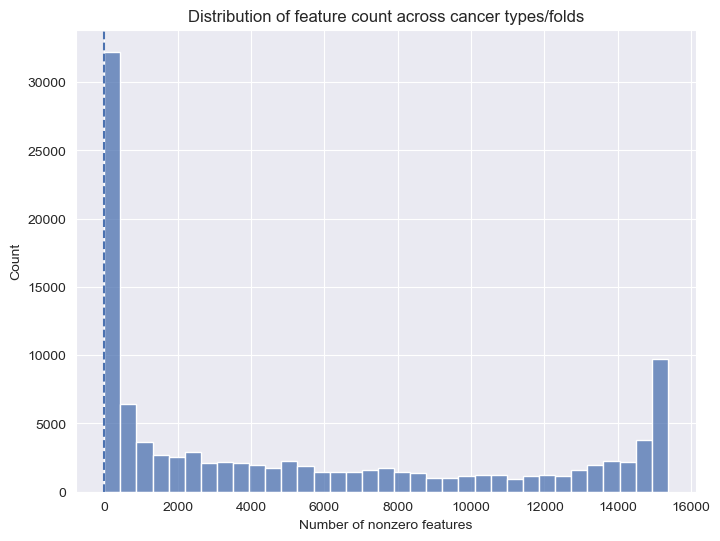

In [6]:
sns.set({'figure.figsize': (8, 6)})

sns.histplot(coefs_perf_df.nz_coefs)
plt.title('Distribution of feature count across cancer types/folds')
plt.xlabel('Number of nonzero features')

# calculate quantile cutoff if included
# models below the cutoff get filtered out in the next cell, here we'll visualize the
# distribution and a few of the filtered rows
if quantile_cutoff is not None:
    nz_coefs_cutoff = coefs_perf_df.nz_coefs.quantile(q=quantile_cutoff)
    plt.gca().axvline(nz_coefs_cutoff, linestyle='--')
    print('cutoff:', nz_coefs_cutoff)
    
coefs_perf_df.loc[coefs_perf_df.nz_coefs.sort_values()[:8].index, :]

### Get "best" LASSO parameters and compare performance across all genes

We want to use two different strategies to pick the "best" LASSO parameter:

1. Choose the top 25% of LASSO parameters based on validation set AUPR, then take the smallest model (least nonzero coefficients) in that set. This is the "parsimonious" approach that assumes that smaller models will generalize better.
2. Choose the top LASSO parameter based solely on validation set AUPR, without considering model size. This is the "non-parsimonious" approach.

We'll do this for each gene/cancer type in the dataset below, and plot the distribution of differences between the two strategies, as a way to quantify which strategy is "better" for generalization across cancer types.

In [7]:
def get_top_and_smallest_diff(gene, cancer_type):
    top_df = (
        perf_df[(perf_df.gene == gene) &
                (perf_df.data_type == 'cv') &
                (perf_df.signal == 'signal') &
                (perf_df.holdout_cancer_type == cancer_type)]
          .groupby(['lasso_param'])
          .agg(np.mean)
          .drop(columns=['seed', 'fold'])
          .rename(columns={'auroc': 'mean_auroc', 'aupr': 'mean_aupr'})
          .sort_values(by='mean_aupr', ascending=False)
    )
    top_df.index = top_df.index.astype(float)
    top_df['aupr_rank'] = top_df.mean_aupr.rank(ascending=False)
    top_5_lasso = top_df.loc[top_df.aupr_rank <= 5, :].index
    
    # get parameter with best validation performance
    top_lasso_param = top_5_lasso[0]

    # get parameter in top 5 validation performance with least nonzero coefficients
    smallest_lasso_param = (
        nz_coefs_df[(nz_coefs_df.gene == gene) & 
                    (nz_coefs_df.cancer_type == cancer_type) &
                    (nz_coefs_df.lasso_param.isin(top_5_lasso))]
          .groupby(['lasso_param'])
          .agg(np.mean)
          .drop(columns=['seed', 'fold'])
          .sort_values(by='nz_coefs', ascending=True)
    ).index[0]
    
    holdout_df = (
        perf_df[(perf_df.gene == gene) &
                (perf_df.data_type == 'test') &
                (perf_df.signal == 'signal') &
                (perf_df.holdout_cancer_type == cancer_type)]
          .groupby(['lasso_param'])
          .agg(np.mean)
          .drop(columns=['seed', 'fold'])
          .rename(columns={'auroc': 'mean_auroc', 'aupr': 'mean_aupr'})
    )
    
    top_smallest_diff = (
        holdout_df.loc[top_lasso_param, 'mean_aupr'] -
        holdout_df.loc[smallest_lasso_param, 'mean_aupr']
    )
    return [gene, cancer_type, top_lasso_param, smallest_lasso_param, top_smallest_diff]

print(get_top_and_smallest_diff('SETD2', 'KIRP'))

['SETD2', 'KIRP', 10.0, 0.05, 0.22873374999999996]


In [8]:
all_top_smallest_diff_df = []

for gene in perf_df.gene.unique():
    for cancer_type in perf_df[perf_df.gene == gene].holdout_cancer_type.unique():
        all_top_smallest_diff_df.append(get_top_and_smallest_diff(gene, cancer_type))
        
all_top_smallest_diff_df = pd.DataFrame(
    all_top_smallest_diff_df,
    columns=['gene', 'cancer_type', 'top_lasso_param',
             'smallest_lasso_param', 'top_smallest_diff']
)

all_top_smallest_diff_df['best'] = 'top'
all_top_smallest_diff_df.loc[
    all_top_smallest_diff_df.top_smallest_diff < 0, 'best'
] = 'smallest'
all_top_smallest_diff_df.loc[
    all_top_smallest_diff_df.top_smallest_diff == 0, 'best'
] = 'zero'

print(all_top_smallest_diff_df.best.value_counts())
all_top_smallest_diff_df.head()

top         137
smallest     87
zero         54
Name: best, dtype: int64


,gene,cancer_type,top_lasso_param,smallest_lasso_param,top_smallest_diff,best
0,MAP3K1,BRCA,10.00,0.01,-0.004655,smallest
1,MAP3K1,UCEC,1.00,0.01,-0.019831,smallest
2,TP53,PRAD,0.05,0.01,-0.016208,smallest
3,TP53,READ,0.05,0.01,-0.001199,smallest
4,TP53,KICH,0.05,0.01,0.059441,top


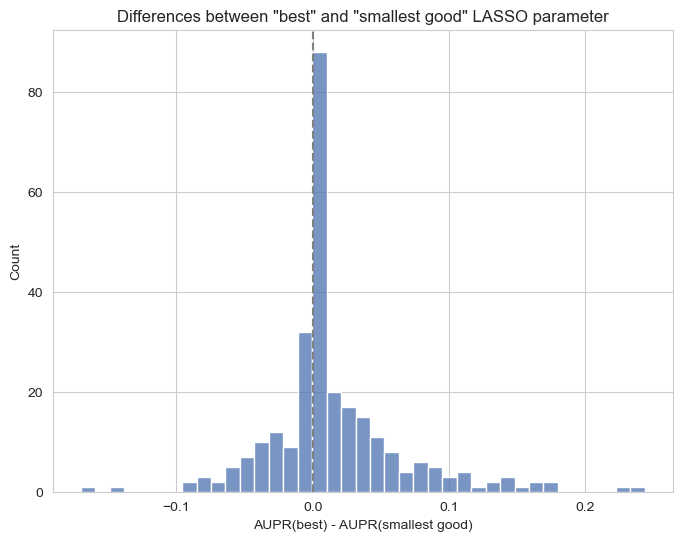

In [9]:
sns.set({'figure.figsize': (8, 6)})
sns.set_style('whitegrid')

sns.histplot(all_top_smallest_diff_df.top_smallest_diff)
plt.title('Differences between "best" and "smallest good" LASSO parameter')
plt.xlabel('AUPR(best) - AUPR(smallest good)')
plt.gca().axvline(0, color='grey', linestyle='--')

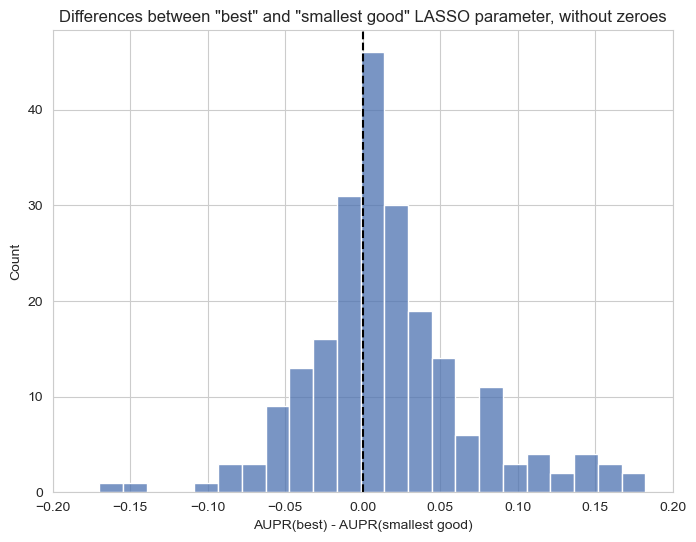

In [10]:
sns.set({'figure.figsize': (8, 6)})
sns.set_style('whitegrid')

sns.histplot(
    all_top_smallest_diff_df[all_top_smallest_diff_df.top_smallest_diff != 0.0].top_smallest_diff
)
plt.xlim(-0.2, 0.2)
plt.title('Differences between "best" and "smallest good" LASSO parameter, without zeroes')
plt.xlabel('AUPR(best) - AUPR(smallest good)')
plt.gca().axvline(0, color='black', linestyle='--')

In [11]:
all_top_smallest_diff_df.sort_values(by='top_smallest_diff', ascending=False).head(10)

,gene,cancer_type,top_lasso_param,smallest_lasso_param,top_smallest_diff,best
200,PIK3CA,READ,0.05,0.005,0.243579,top
258,SETD2,KIRP,10.00,0.050,0.228734,top
257,SETD2,KIRC,10.00,0.050,0.174029,top
186,PTEN,STAD,0.05,0.005,0.172630,top
187,PTEN,LUSC,0.05,0.005,0.165499,top
158,EP300,CESC,10.00,0.010,0.165495,top
178,PTEN,LGG,0.05,0.005,0.157514,top
102,PDGFRA,LUSC,0.01,0.005,0.146060,top
162,ATRX,SARC,0.05,0.005,0.143666,top
273,KRAS,BLCA,0.05,0.010,0.140137,top


In [12]:
all_top_smallest_diff_df.sort_values(by='top_smallest_diff', ascending=True).head(10)

,gene,cancer_type,top_lasso_param,smallest_lasso_param,top_smallest_diff,best
49,CDKN2A,LGG,0.05,0.010,-0.169929,smallest
122,SMAD4,LUAD,0.05,0.005,-0.146155,smallest
172,CTNNB1,SKCM,10.00,0.050,-0.094103,smallest
121,SMAD4,HNSC,0.05,0.005,-0.086531,smallest
249,NFE2L2,UCEC,0.10,0.010,-0.084808,smallest
25,RB1,LIHC,0.05,0.005,-0.081980,smallest
22,RB1,LUSC,0.05,0.010,-0.075335,smallest
19,TP53,LGG,0.05,0.010,-0.065263,smallest
175,CTNNB1,LIHC,1.00,0.050,-0.064836,smallest
204,PIK3CA,OV,0.05,0.005,-0.061095,smallest


### Visualize performance by cancer type

We'll do this using the "best" parameters.

In [13]:
cv_perf_df = (
    perf_df[(perf_df.data_type == 'cv') &
            (perf_df.signal == 'signal')]
      .drop(columns=['experiment', 'signal'])
      .rename(columns={'holdout_cancer_type': 'cancer_type'})
).copy()
cv_perf_df.lasso_param = cv_perf_df.lasso_param.astype(float)

print(cv_perf_df.shape)
cv_perf_df.head()

(35520, 8)


,auroc,aupr,gene,cancer_type,seed,data_type,fold,lasso_param
2,0.49347,0.062197,MAP3K1,BRCA,1,cv,0,1.0
5,0.34336,0.054755,MAP3K1,BRCA,1,cv,1,1.0
8,0.29343,0.035233,MAP3K1,BRCA,1,cv,2,1.0
11,0.50560,0.059116,MAP3K1,BRCA,1,cv,3,1.0
2,0.44683,0.054498,MAP3K1,BRCA,1,cv,0,50.0


In [14]:
test_perf_df = (
    perf_df[(perf_df.data_type == 'test') &
            (perf_df.signal == 'signal')]
      .drop(columns=['experiment', 'signal'])
      .rename(columns={'holdout_cancer_type': 'cancer_type'})
).copy()
test_perf_df.lasso_param = test_perf_df.lasso_param.astype(float)

print(test_perf_df.shape)
test_perf_df.head()

(35520, 8)


,auroc,aupr,gene,cancer_type,seed,data_type,fold,lasso_param
1,0.43147,0.062268,MAP3K1,BRCA,1,test,0,1.0
4,0.36746,0.084355,MAP3K1,BRCA,1,test,1,1.0
7,0.55274,0.142940,MAP3K1,BRCA,1,test,2,1.0
10,0.48715,0.096824,MAP3K1,BRCA,1,test,3,1.0
1,0.56990,0.087144,MAP3K1,BRCA,1,test,0,50.0


In [15]:
# get performance using "best" lasso parameter, across all seeds and folds
# (so we can plot the distribution/visualize the variance across CV splits)
best_perf_df = (
    all_top_smallest_diff_df.loc[:, ['gene', 'cancer_type', 'top_lasso_param']]
      .merge(cv_perf_df,
             left_on=['gene', 'cancer_type', 'top_lasso_param'],
             right_on=['gene', 'cancer_type', 'lasso_param'])
      .drop(columns=['lasso_param'])
      .rename(columns={'auroc': 'cv_auroc',
                       'aupr': 'cv_aupr'})
      .merge(test_perf_df,
             left_on=['gene', 'cancer_type', 'top_lasso_param', 'seed', 'fold'],
             right_on=['gene', 'cancer_type', 'lasso_param', 'seed', 'fold'])
      .drop(columns=['lasso_param'])
      .rename(columns={'auroc': 'test_auroc',
                       'aupr': 'test_aupr'})
)
best_perf_df['cv_test_auroc_diff'] = (
    best_perf_df.cv_auroc - best_perf_df.test_auroc
)
best_perf_df['cv_test_aupr_diff'] = (
    best_perf_df.cv_aupr - best_perf_df.test_aupr
)

print(best_perf_df.shape)
best_perf_df.sort_values(by='cv_test_aupr_diff', ascending=False).head()

(2220, 13)


,gene,cancer_type,top_lasso_param,cv_auroc,cv_aupr,seed,data_type_x,fold,test_auroc,test_aupr,data_type_y,cv_test_auroc_diff,cv_test_aupr_diff
256,BRAF,LUAD,0.1,0.95771,0.95770,42,cv,0,0.52193,0.045647,test,0.43578,0.912053
258,BRAF,LUAD,0.1,0.96140,0.94815,42,cv,2,0.38148,0.080946,test,0.57992,0.867204
278,BRAF,COAD,1.0,0.92438,0.92051,42,cv,2,0.41544,0.056430,test,0.50894,0.864080
275,BRAF,COAD,1.0,0.92090,0.91221,1,cv,3,0.50242,0.057390,test,0.41848,0.854820
257,BRAF,LUAD,0.1,0.96043,0.96116,42,cv,1,0.52088,0.120190,test,0.43955,0.840970


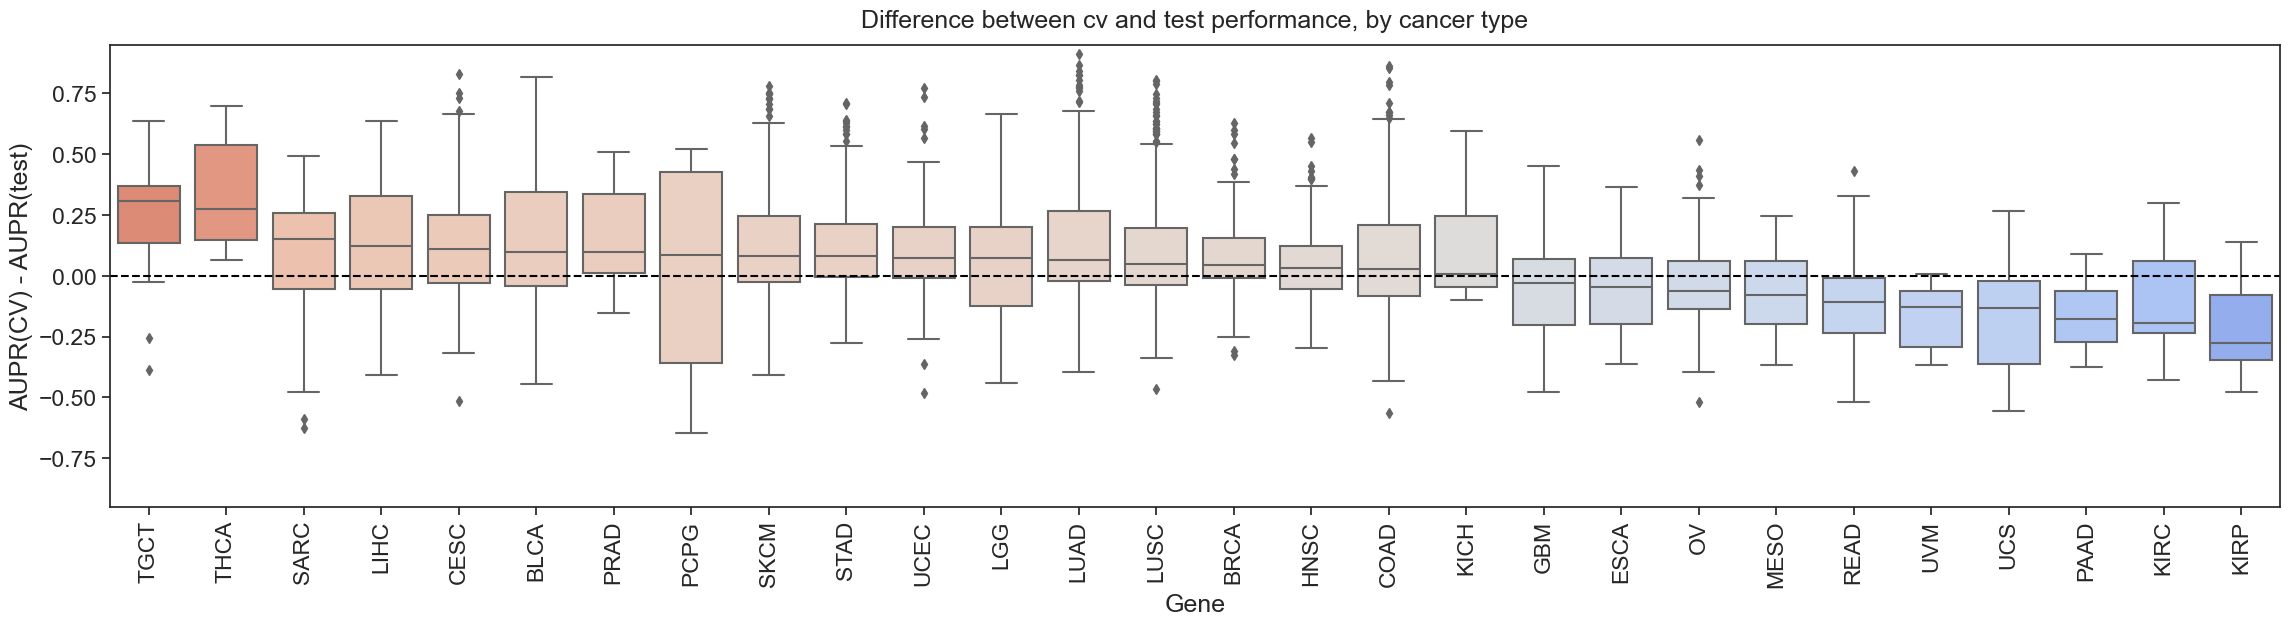

In [16]:
# plot difference in validation and test performance for each gene
sns.set({'figure.figsize': (28, 6)})
sns.set_style('ticks')

# order boxes by median (cv - test) diff per gene
medians = (best_perf_df
    .groupby(['cancer_type'])
    .agg(np.median)
    .sort_values(by='cv_test_aupr_diff', ascending=False)
)['cv_test_aupr_diff'].values

cancer_type_order = (best_perf_df
    .groupby(['cancer_type'])
    .agg(np.median)
    .sort_values(by='cv_test_aupr_diff', ascending=False)
).index.get_level_values(0).values

with sns.plotting_context('notebook', font_scale=1.5):
    # map median performance values to colors on scale centered at 0
    cmap = sns.color_palette('coolwarm', as_cmap=True)
    norm = Normalize(vmin=-0.5, vmax=0.5)
    ax = sns.boxplot(data=best_perf_df, order=cancer_type_order,
                     x='cancer_type', y='cv_test_aupr_diff',
                     palette=[cmap(norm(m)) for m in medians])
    ax.axhline(0.0, linestyle='--', color='black')
    plt.xticks(rotation=90)
    plt.xlabel('Gene')
    plt.title(f'Difference between cv and test performance, by cancer type', y=1.02)
    plt.ylim(-0.95, 0.95)
    plt.ylabel('AUPR(CV) - AUPR(test)')